<a href="https://colab.research.google.com/github/zugzwang03/Machine-Learning-Materials/blob/main/image_segmentation_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete91CER3/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete91CER3/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [9]:
def normalize(input_image, input_mask):

	# Normalize the pixel range values between [0:1]
	img = tf.cast(input_image, dtype=tf.float32) / 255.0
	input_mask -= 1
	return img, input_mask

@tf.function
def load_train_ds(dataset):
	img = tf.image.resize(dataset['image'],
						size=(width, height))
	mask = tf.image.resize(dataset['segmentation_mask'],
						size=(width, height))

	if tf.random.uniform(()) > 0.5:
		img = tf.image.flip_left_right(img)
		mask = tf.image.flip_left_right(mask)

	img, mask = normalize(img, mask)
	return img, mask

@tf.function
def load_test_ds(dataset):
	img = tf.image.resize(dataset['image'],
						size=(width, height))
	mask = tf.image.resize(dataset['segmentation_mask'],
						size=(width, height))

	img, mask = normalize(img, mask)
	return img, mask

In [5]:
info.splits['train']

<SplitInfo num_examples=3680, num_shards=4>

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples

# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# For VGG16 this is the input size
width, height = 224, 224

In [11]:
# num_parallel_calls=tf.data.AUTOTUNE is an argument
# for map that tells TensorFlow to automatically determine
# the number of parallel threads to use for applying the preprocessing functions.
# This can improve performance by utilizing multiple CPU cores.


# Caching (cache()): This operation caches the preprocessed data from train in memory or on local storage. This can significantly speed up training since subsequent epochs (iterations over the data) won't need to repeat the preprocessing steps. However, caching requires sufficient storage space.
# Shuffling (shuffle(BUFFER_SIZE)): This step shuffles the training data before batching. Shuffling helps prevent the model from learning patterns specific to the data order and improves generalization. BUFFER_SIZE specifies the size of the buffer used for shuffling.
# Batching (batch(BATCH_SIZE)): This operation groups elements from the shuffled data into batches of size BATCH_SIZE. Batching improves efficiency by processing multiple data points simultaneously on the GPU or TPU.
# Repeating (repeat()): This ensures the training data is iterated over multiple times (epochs) during training.
# Prefetching (prefetch(buffer_size=tf.data.AUTOTUNE)): Prefetching overlaps data preprocessing with model training. While the model trains on one batch, the next batch is being preprocessed in the background. This can improve training speed by hiding some of the preprocessing latency. tf.data.AUTOTUNE again lets TensorFlow determine the optimal prefetching buffer size.

train = dataset['train'].map(load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

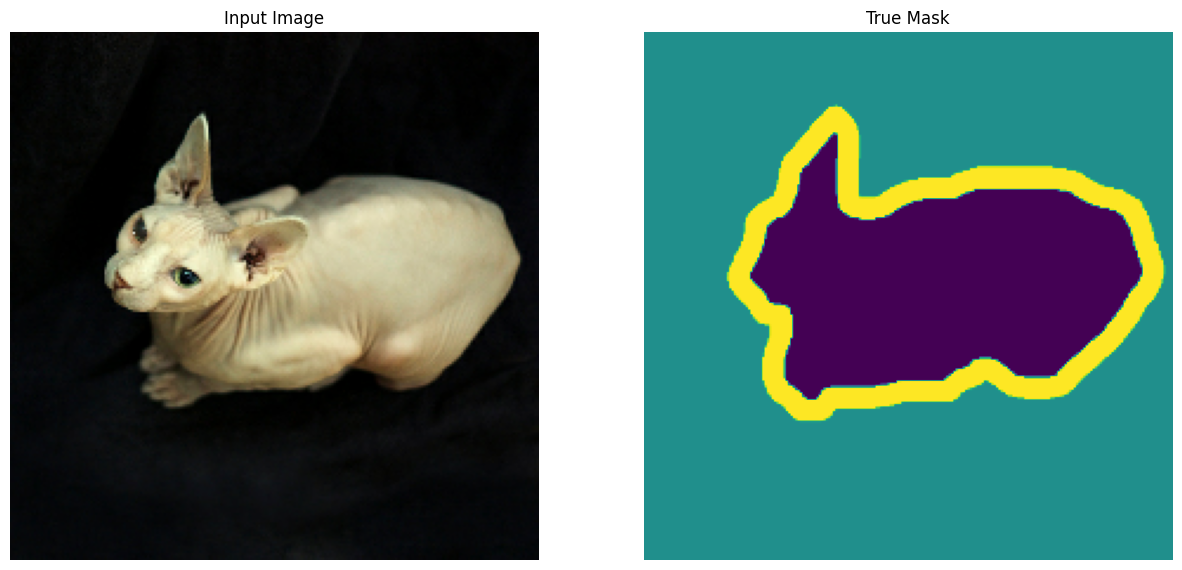

In [16]:
# plt.subplot: This function is used to create subplots within a figure. It allows you to arrange multiple plots on a single page.

# 1: This is the first argument to plt.subplot and represents the number of rows of subplots. In this case, you're creating a single row of subplots.

# len(display_list): This is the second argument and specifies the number of columns for the subplots. It uses the length (len) of the display_list to determine the number of columns. This means the number of columns will adapt based on the size of the display_list.

# i+1: This is the third argument and indicates the index of the subplot within the grid. The index starts from 1 (not 0). Adding 1 to i ensures the correct subplot is selected based on the current loop iteration (i).

# In matplotlib, the plt.axis('off') command instructs the plotting library to hide all the axis elements associated with the current plot.

def display_images(display_list):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask',
			'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
		plt.axis('off')

	plt.show()


for img, mask in train.take(1):
	sample_image, sample_mask = img, mask
	display_list = sample_image, sample_mask

display_images(display_list)

In [15]:
train.take

<bound method DatasetV2.take of <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>>

## U-Net based on CNN segmentation

VGG16 model being used

VGG16 is a convolutional neural network (CNN) architecture designed for image classification tasks. It was introduced by the Visual Geometry Group (VGG) at the University of Oxford.

Deep Architecture: VGG16 is a relatively deep model for its time, consisting of 16 layers (13 convolutional layers and 3 fully-connected layers). This depth allows it to learn complex features from images.

Simple Building Blocks: Despite its depth, VGG16 relies on a relatively simple architecture. It primarily uses small 3x3 filters in convolutional layers, stacked together with pooling layers. This approach avoids introducing a large number of hyperparameters that need tuning.

Strong Performance: VGG16 achieved state-of-the-art performance on image classification tasks when it was first introduced. It was a finalist in the ILSVRC-2014 image recognition competition.

Transfer Learning: VGG16, like many other CNNs, is often used for transfer learning. The pre-trained weights learned on a large dataset like ImageNet can be a good starting point for training models on new, smaller datasets. This can significantly improve the performance compared to training from scratch.





In [18]:
# This line loads the VGG16 model from Keras applications using keras.applications.vgg16.VGG16.
# include_top=False argument excludes the final classification layers of VGG16. We're only interested in the feature extraction capabilities of the convolutional layers.
# input_shape=(width, height, 3) specifies the input shape for the model. This needs to match the format of your images (width, height, and 3 color channels).

base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(width, height, 3))

# This defines a list named layer_names containing specific layer names within the pre-trained VGG16 model.
# These layers likely correspond to the pooling layers at the end of each convolutional block in VGG16. They represent the extracted features at different levels of abstraction.

layer_names = [
	'block1_pool',
	'block2_pool',
	'block3_pool',
	'block4_pool',
	'block5_pool',
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# This effectively freezes the weights of the VGG16 model, preventing them from being updated during training. We want to leverage the pre-trained features from VGG16 and focus on training additional layers on top of it.

base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
base_model.get_layer('block5_pool').output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [38]:
def fcn8_decoder(convs, n_classes):
    # f1, f2, f3, f4, f5 are all the max pooling layers used for feature extraction purpose
    f1, f2, f3, f4, p5 = convs
    n = 4096
    # 7 * 7 is the kernel size
    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    # extracting high level features twice by using 7 * 7 and 1 * 1 kernel size filtering
    f5 = c7

    # upsample the output of the encoder
    # then crop extra pixels that were introduced

    # tf.keras.layers.Conv2DTranspose: This class from Keras creates a Conv2DTranspose layer, which is the core operation in this line.
    # n_classes: This argument specifies the number of output filters or channels for the layer. In semantic segmentation, it likely corresponds to the number of classes you want to predict for each pixel in the image (e.g., background, object, etc.).
    # kernel_size=(4, 4): This defines the size of the filter kernel used in the deconvolution operation. A 4x4 kernel means a square with dimensions 4 rows x 4 columns.
    # strides=(2, 2): This specifies the strides for the deconvolution. Strides of (2, 2) indicate that the filter kernel is applied with a jump of 2 pixels horizontally and vertically in each step, effectively doubling the output height and width compared to the input.
    # use_bias=False: This argument controls whether a bias vector is added to the output of the convolution. Here, it's set to False, meaning no bias term is added.
    # (f5): This part represents the input to the layer. Likely, f5 is a tensor containing the feature maps extracted from the VGG16 model or from a previous step in the decoder.

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)
    # load the pool 4 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)
    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])
    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)
    # load the pool 3 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)
    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])
    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), use_bias=False)(o)
    # append a softmax to get the class probabilities
    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [39]:
def segmentation_model():
    inputs = keras.layers.Input(shape=(width, height, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs, 3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


opt = keras.optimizers.Adam()

model = segmentation_model()

# Setting from_logits=True indicates that the model's output already represents logits (not probabilities). The loss function directly applies the crossentropy calculation on these logits without applying softmax internally.
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


2/2 [==============================] - 55s 27s/step


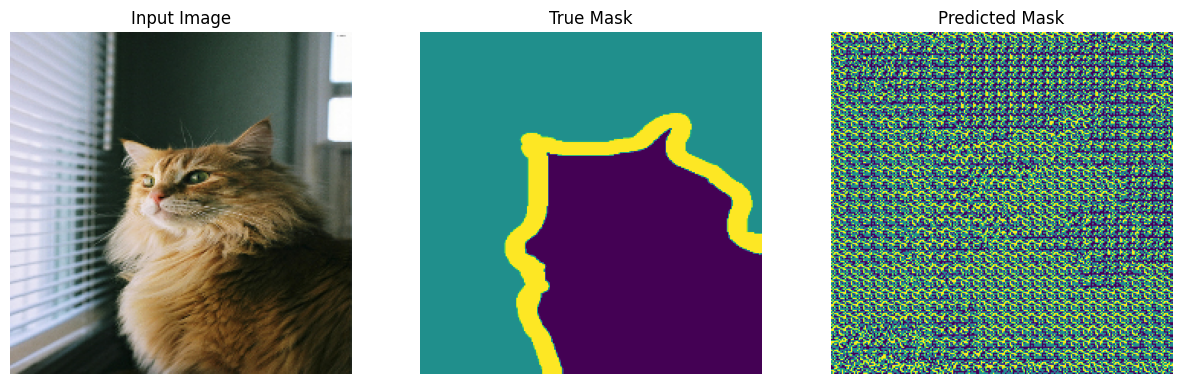

In [52]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions(train_ds)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 6/57 [==>...........................] - ETA: 1:25:48 - loss: 1.3328 - accuracy: 0.3461

In [ ]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area

		iou = (intersection + smoothening_factor) / \
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	return class_wise_iou, class_wise_dice_score

In [ ]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)